# net_fish_sonar

## Dataset creation

Hairy process:
- net_sonar and fish_sonar merged into net_fish_sonar dataset
- we make train/val split with this data
- we add the cfc_gray_tiny dataset into train and make this setup:
    - Train: 1600 (8 bags) images (net+fish) from net_fish_sonar dataset X2 + 8000 images (fish) from cfc_gray_tiny = 11200 images 
    - Val: 400 (2 bags) images (net+fish) from net_fish_sonar dataset
- we made a .txt with paths to all this above
- we feed these path during training


### Creating lables folder and Remapping net to get 1 as label 

In [2]:
from pathlib import Path

# Paths (run this from repo root; adjust if needed)
RAW_DIR = Path("../../solaqua/data/net_labels_raw")
OUT_DIR = Path("../../solaqua/data/net_fish_sonar/labels")

OUT_DIR.mkdir(parents=True, exist_ok=True)

num_files = 0
num_labels_changed = 0

for src in RAW_DIR.glob("*.txt"):
    stem = src.stem  # e.g. "0a05d92c-bag3_1724154956410393300"
    # remove the first id before the first '-'
    parts = stem.split("-", 1)
    if len(parts) == 2:
        new_stem = parts[1]          # "bag3_1724154956410393300"
    else:
        new_stem = stem              # fallback (no '-')

    dst = OUT_DIR / f"{new_stem}.txt"

    out_lines = []
    with src.open("r") as f:
        for line in f:
            s = line.strip()
            if not s:
                continue
            bits = s.split()
            # YOLO: cls cx cy w h ...
            if bits[0] == "0":
                bits[0] = "1"
                num_labels_changed += 1
            out_lines.append(" ".join(bits))

    with dst.open("w") as f:
        if out_lines:
            f.write("\n".join(out_lines) + "\n")

    num_files += 1

print(f"Processed {num_files} label files.")
print(f"Changed {num_labels_changed} class ids from 0 -> 1.")
print(f"New labels written to: {OUT_DIR.resolve()}")

Processed 2000 label files.
Changed 1999 class ids from 0 -> 1.
New labels written to: /cluster/home/henrban/SOLAQUA-UOD/solaqua/data/net_fish_sonar/labels


Mark that this file does not have a line bag1_1724155131226089200. it should be updated with: 1 0.4945898 0.8498062 0.2294897 0.0406977. 
A fault happened during manual labeling

### Adding fishes from solaqua data

In [3]:
from pathlib import Path

FISH_RAW_DIR = Path("../../solaqua/data/fish_labels_raw")
NET_LABEL_DIR = Path("../../solaqua/data/net_fish_sonar/labels")

assert NET_LABEL_DIR.exists(), f"{NET_LABEL_DIR} does not exist"

files_processed = 0
fish_boxes_added = 0
created_files = 0
skipped_already_had_fish = 0

for fish_file in FISH_RAW_DIR.glob("*.txt"):
    stem = fish_file.stem  # e.g. "0a05d92c-bag3_1724..."
    parts = stem.split("-", 1)
    if len(parts) == 2:
        new_stem = parts[1]    # "bag3_1724..."
    else:
        new_stem = stem

    target = NET_LABEL_DIR / f"{new_stem}.txt"

    # read fish labels
    fish_lines = []
    with fish_file.open("r") as f:
        for line in f:
            s = line.strip()
            if not s:
                continue
            bits = s.split()
            # fish should already be class 0; we leave it as-is
            fish_lines.append(" ".join(bits))

    if not fish_lines:
        continue  # nothing to add

    # read existing target (if any)
    existing_lines = []
    if target.exists():
        with target.open("r") as f:
            for line in f:
                s = line.strip()
                if not s:
                    continue
                existing_lines.append(s)

        # check if there are already fish boxes (class 0) there
        if any(l.split()[0] == "0" for l in existing_lines):
            skipped_already_had_fish += 1
            files_processed += 1
            continue
    else:
        created_files += 1

    # merge: existing (possibly nets) + fish
    merged = existing_lines + fish_lines
    fish_boxes_added += len(fish_lines)

    with target.open("w") as f:
        f.write("\n".join(merged) + "\n")

    files_processed += 1

print(f"Processed fish label files: {files_processed}")
print(f"Created new label files (fish-only): {created_files}")
print(f"Fish boxes added: {fish_boxes_added}")
print(f"Skipped files that already had fish labels: {skipped_already_had_fish}")
print(f"Final labels dir: {NET_LABEL_DIR.resolve()}")


Processed fish label files: 308
Created new label files (fish-only): 0
Fish boxes added: 693
Skipped files that already had fish labels: 0
Final labels dir: /cluster/home/henrban/SOLAQUA-UOD/solaqua/data/net_fish_sonar/labels


### getting images for solaqua data 


In [4]:
from pathlib import Path
import shutil

def copy_all_sonar_images(src_root, dst_root):
    """
    Copy all images from:
        src_root/train
        src_root/val
        src_root/test
    into:
        dst_root/
        
    Keeps filenames, supports jpg/png/jpeg.
    """

    src_root = Path(src_root)
    dst_root = Path(dst_root)

    # Ensure destination exists
    dst_root.mkdir(parents=True, exist_ok=True)

    allowed_ext = {".jpg", ".jpeg", ".png"}

    copied = 0
    skipped = 0

    # Loop over splits
    for split in ["train", "val", "test"]:
        split_dir = src_root / split
        if not split_dir.exists():
            print(f"[WARN] Split folder does not exist: {split_dir}")
            continue

        print(f"[INFO] Scanning {split_dir}...")

        for img in split_dir.glob("*"):
            if img.suffix.lower() not in allowed_ext:
                continue

            dst_path = dst_root / img.name

            # If image already exists, skip
            if dst_path.exists():
                skipped += 1
                continue

            shutil.copy2(img, dst_path)
            copied += 1

    print("\n===== SUMMARY =====")
    print(f"Copied images: {copied}")
    print(f"Skipped existing: {skipped}")
    print(f"Images now in: {dst_root.resolve()}")
    print("===================\n")


# Example usage:
copy_all_sonar_images(
    src_root="../../solaqua/data/net_sonar/images",
    dst_root="../../solaqua/data/net_fish_sonar/images"
)


[INFO] Scanning ../../solaqua/data/net_sonar/images/train...
[INFO] Scanning ../../solaqua/data/net_sonar/images/val...
[INFO] Scanning ../../solaqua/data/net_sonar/images/test...

===== SUMMARY =====
Copied images: 2000
Skipped existing: 0
Images now in: /cluster/home/henrban/SOLAQUA-UOD/solaqua/data/net_fish_sonar/images



### validate if ok

In [2]:
from pathlib import Path
from collections import Counter
import numpy as np

def summarize_yolo_dataset(images_dir, labels_dir, class_names=None):
    images_dir = Path(images_dir)
    labels_dir = Path(labels_dir)

    img_files = sorted([p for p in images_dir.glob("*") if p.suffix.lower() in [".jpg", ".jpeg", ".png"]])
    label_files = sorted(labels_dir.glob("*.txt"))

    # Map stems: image: label
    img_stems = {p.stem for p in img_files}
    label_stems = {p.stem for p in label_files}

    # Matching
    matched = img_stems & label_stems
    unlabeled_imgs = img_stems - label_stems
    orphan_labels = label_stems - img_stems

    class_counts = Counter()
    box_counts = []

    malformed = []

    # Parse label files
    for lf in label_files:
        try:
            with lf.open("r") as f:
                lines = [ln.strip() for ln in f.readlines() if ln.strip()]
        except:
            malformed.append((lf.name, "cannot read file"))
            continue

        count = 0
        for ln in lines:
            parts = ln.split()
            if len(parts) != 5:
                malformed.append((lf.name, ln))
                continue

            cls = parts[0]
            if not cls.isdigit():
                malformed.append((lf.name, ln))
                continue

            cls = int(cls)
            class_counts[cls] += 1
            count += 1

        box_counts.append(count)

    print("\n" + "="*70)
    print("📊 YOLO DATASET SUMMARY")
    print("="*70)
    print(f"Images dir: {images_dir.resolve()}")
    print(f"Labels dir: {labels_dir.resolve()}")
    print("-"*70)
    print(f"Total images:            {len(img_files)}")
    print(f"Total label files:       {len(label_files)}")
    print(f"Images WITH labels:      {len(matched)}")
    print(f"Images WITHOUT labels:   {len(unlabeled_imgs)}")
    print(f"Label files w/out image: {len(orphan_labels)}")

    print("\n📦 Instance statistics")
    print("-"*70)
    if class_names:
        for cid, count in sorted(class_counts.items()):
            cname = class_names.get(cid, f"class_{cid}")
            print(f"  {cid:2d} ({cname:10s}): {count}")
    else:
        for cid, count in sorted(class_counts.items()):
            print(f"  {cid:2d}: {count}")

    total_boxes = sum(class_counts.values())
    avg_boxes = total_boxes / len(label_files) if label_files else 0

    print("\n📐 Box count per file")
    print("-"*70)
    if box_counts:
        print(f"Min boxes/file: {np.min(box_counts)}")
        print(f"Max boxes/file: {np.max(box_counts)}")
        print(f"Avg boxes/file: {np.mean(box_counts):.2f}")
    else:
        print("No boxes")

    if malformed:
        print("\n⚠️ Malformed label lines found:")
        for name, line in malformed[:20]:
            print(f"  {name}: {line}")
        if len(malformed) > 20:
            print(f"  ... and {len(malformed)-20} more")

    print("\n📝 Examples (first 5 label files):")
    for lf in list(label_files)[:5]:
        print(f"\n--- {lf.name} ---")
        print(lf.read_text().strip())

    print("\nDone.")
    print("="*70)


# Example usage:
summarize_yolo_dataset(
    images_dir="../../solaqua/data/net_fish_sonar/images",
    labels_dir="../../solaqua/data/net_fish_sonar/labels",
    class_names={0: "fish", 1: "net"}
)



📊 YOLO DATASET SUMMARY
Images dir: /cluster/home/henrban/SOLAQUA-UOD/solaqua/data/net_fish_sonar/images
Labels dir: /cluster/home/henrban/SOLAQUA-UOD/solaqua/data/net_fish_sonar/labels
----------------------------------------------------------------------
Total images:            2000
Total label files:       2000
Images WITH labels:      2000
Images WITHOUT labels:   0
Label files w/out image: 0

📦 Instance statistics
----------------------------------------------------------------------
   0 (fish      ): 693
   1 (net       ): 2000

📐 Box count per file
----------------------------------------------------------------------
Min boxes/file: 1
Max boxes/file: 13
Avg boxes/file: 1.35

📝 Examples (first 5 label files):

--- bag10_1724166879526834500.txt ---
1 0.5180348258706468 0.8747927031509122 0.17509673852957433 0.07131011608623553

--- bag10_1724166879723100100.txt ---
1 0.511746821448314 0.8830845771144279 0.1605859590934218 0.05472636815920396

--- bag10_1724166879970507300.txt -

## making train/val/test split on solaqua data

In [ ]:
from pathlib import Path
from typing import Optional
import shutil

# ---------- CONFIG ----------

# Source (flat) dataset
SRC_ROOT = Path("../../solaqua/data/net_fish_sonar")
SRC_IMG_DIR = SRC_ROOT / "images"
SRC_LBL_DIR = SRC_ROOT / "labels"

# Destination split dataset
DST_ROOT = Path("../../solaqua/data/net_fish_sonar_split")
DST_IMG_DIR = DST_ROOT / "images"
DST_LBL_DIR = DST_ROOT / "labels"

# Bag-based split (edit if needed)
TRAIN_BAGS = {"bag1", "bag2", "bag4", "bag5", "bag7","bag8", "bag9", "bag10"}
VAL_BAGS   = {"bag3", "bag6"}
TEST_BAGS  = {}  # optional; leave empty set() if you don’t want test

# Copy or move?
COPY = True  # True = copy, False = move

# ----------------------------

def bag_from_stem(stem: str) -> Optional[str]:
    """
    Extract bag prefix from filename stem, e.g.
    'bag3_1724154....' -> 'bag3'
    """
    parts = stem.split("_", 1)
    if not parts:
        return None
    return parts[0]  # 'bagX'

def split_for_bag(bag: str) -> Optional[str]:
    if bag in TRAIN_BAGS:
        return "train"
    if bag in VAL_BAGS:
        return "val"
    if bag in TEST_BAGS:
        return "test"
    return None

def main():
    assert SRC_IMG_DIR.exists(), f"{SRC_IMG_DIR} not found"
    assert SRC_LBL_DIR.exists(), f"{SRC_LBL_DIR} not found"

    # Create destination dirs
    for split in ["train", "val", "test"]:
        (DST_IMG_DIR / split).mkdir(parents=True, exist_ok=True)
        (DST_LBL_DIR / split).mkdir(parents=True, exist_ok=True)

    exts = {".jpg", ".jpeg", ".png"}
    img_files = [p for p in SRC_IMG_DIR.iterdir() if p.suffix.lower() in exts]

    stats = {"train": 0, "val": 0, "test": 0, "skipped": 0, "missing_label": 0}

    for img_path in img_files:
        stem = img_path.stem  # e.g. 'bag3_1724...'
        bag = bag_from_stem(stem)
        split = split_for_bag(bag) if bag else None

        if split is None:
            print(f"[WARN] Skipping {img_path.name}: unknown or missing bag prefix '{bag}'")
            stats["skipped"] += 1
            continue

        lbl_path = SRC_LBL_DIR / f"{stem}.txt"
        if not lbl_path.exists():
            print(f"[WARN] No label for image {img_path.name} (expected {lbl_path.name})")
            stats["missing_label"] += 1

        # Dest paths
        dst_img = DST_IMG_DIR / split / img_path.name
        dst_lbl = DST_LBL_DIR / split / lbl_path.name

        # copy or move
        if COPY:
            shutil.copy2(img_path, dst_img)
            if lbl_path.exists():
                shutil.copy2(lbl_path, dst_lbl)
        else:
            shutil.move(img_path, dst_img)
            if lbl_path.exists():
                shutil.move(lbl_path, dst_lbl)

        stats[split] += 1

    print("\n=== SPLIT SUMMARY ===")
    print(f"Train images: {stats['train']}")
    print(f"Val images  : {stats['val']}")
    print(f"Test images : {stats['test']}")
    print(f"Skipped (no split): {stats['skipped']}")
    print(f"Images missing labels: {stats['missing_label']}")
    print(f"Output root: {DST_ROOT.resolve()}")
    print("======================\n")

if __name__ == "__main__":
    main()



=== SPLIT SUMMARY ===
Train images: 1600
Val images  : 400
Test images : 0
Skipped (no split): 0
Images missing labels: 0
Output root: /cluster/home/henrban/SOLAQUA-UOD/solaqua/data/net_fish_sonar_split



## Setting up training and validation data with cfc also:

In [3]:
from pathlib import Path
import random

# Paths to net_fish_sonar and cfc_gray_tiny image roots
A_IMG_DIR = Path("../../solaqua/data/net_fish_sonar_split/images/train")
B_IMG_DIR = Path("../data/CFC_gray_tiny/images/train")

OUT_LIST = Path("../data/net_fish_cfc_sonar/train_balanced.txt")

# Balance knobs
A_REPEAT = 2        # how many times to repeat each A image
B_SUBSAMPLE = 8000 # how many B images to include per epoch

def collect_images(root: Path):
    exts = {".jpg", ".jpeg", ".png"}
    return [p.resolve() for p in root.rglob("*") if p.suffix.lower() in exts]

# Collect
A_imgs = collect_images(A_IMG_DIR)
B_imgs = collect_images(B_IMG_DIR)

print(f"Dataset A images: {len(A_imgs)}")
print(f"Dataset B images: {len(B_imgs)}")

# Oversample A
A_bal = A_imgs * A_REPEAT

# Subsample B
random.seed(0)
B_bal = random.sample(B_imgs, k=min(B_SUBSAMPLE, len(B_imgs)))

# Combine and shuffle
all_paths = A_bal + B_bal
random.shuffle(all_paths)

OUT_LIST.parent.mkdir(parents=True, exist_ok=True)
OUT_LIST.write_text("\n".join(map(str, all_paths)) + "\n")

print(f"Wrote {len(all_paths)} image paths to {OUT_LIST}")


Dataset A images: 1600
Dataset B images: 48845
Wrote 11200 image paths to ../data/net_fish_cfc_sonar/train_balanced.txt


## Yaml

In [5]:
from pathlib import Path

# Base paths

NOT_ROOT = Path.cwd()
ROOT = NOT_ROOT.parent.parent #this is at root

TRAIN_DIR = ROOT / "aqua_yolo/data/net_fish_cfc_sonar/train_balanced.txt"
VAL_DIR = ROOT / "solaqua/data/net_fish_sonar_split/images/val"
 




# Build YAML (classic YOLO: train/val/test point to images dirs)
dataset_yaml = f"""
train: {TRAIN_DIR.as_posix()}
val:   {VAL_DIR.as_posix()}

nc: 2
names:
    - fish
    - net
"""

# Write YAML next to the dataset
yaml_path = Path("../data/net_fish_cfc_sonar/net_fish_cfc_sonar.yaml")
yaml_path.write_text(dataset_yaml.strip() + "\n", encoding="utf-8")

print("Wrote:", yaml_path)
print("\nPreview:\n")
print(dataset_yaml)


Wrote: ../data/net_fish_cfc_sonar/net_fish_cfc_sonar.yaml

Preview:


train: /cluster/home/henrban/SOLAQUA-UOD/aqua_yolo/data/net_fish_cfc_sonar/train_balanced.txt
val:   /cluster/home/henrban/SOLAQUA-UOD/solaqua/data/net_fish_sonar_split/images/val

nc: 2
names:
    - fish
    - net



# Building

Building (and training) of the model happens in [train.py](../train.py). The model is constructed by the [aquayolo.yaml](../models/aquayolo.yaml), that imports modules from custom blocks (see paragraph below).

### Adding custom blocks

I have added custom blocks to match the architecture as pruposed in the paper. For this to work I have first cloned the ultralytics repo.
- Head to [ultralytics](https://docs.ultralytics.com/guides/model-yaml-config/#source-code-modification) to see how to add custom blocks.
- Files that is modified: [block.py](../../ultralytics/ultralytics/nn/modules/block.py) (classes: AquaResidualBlock, DSAM), [tasks.py](../../ultralytics/ultralytics/nn/tasks.py) (added imports and updated parse_model() for special arguments), [__init__.py](../../ultralytics/ultralytics/nn/modules/__init__.py) (exposing the modules).



# Training

- To train the model run the train.py script by doing: `python3 train.py`

Train.py script:

```bash
from ultralytics import YOLO


if __name__ == "__main__":
    
    # Load custom model cfg
    m = YOLO("models/aquayolo.yaml")
    m.info()  # non-zero FLOPs confirms forward path OK

    m.train(
        data="data/net_fish_cfc_sonar/net_fish_cfc_sonar.yaml",
        pretrained=False,          # Safest off
        epochs=150, 
        patience=50,   
        imgsz=1280,
        batch=48,
        nbs=64,

    # optimizer 
        optimizer="SGD",
        lr0=0.005,                      # conservative for SGD; adjust later if needed
        momentum=0.9,
        weight_decay=5e-4,
        cos_lr=True,
        lrf=0.01,
        warmup_epochs=20,     
                 


    # loss balance – tilt a bit toward recall ????
        box=10.0, cls=0.6, dfl=1.3,


    # augmentation, light
        rect=False,
        mosaic=0.08,
        close_mosaic=100, # only on for the 50 first. 
        mixup=0.05,
        copy_paste=0.0,
        erasing=0.0,
        auto_augment=None,
        hsv_h=0.0, hsv_s=0.0, hsv_v=0.0,
        degrees=3.0, shear=0.0, perspective=0.0,
        translate=0.06,
        scale=0.20,
        fliplr=0.0, flipud=0.0,
        

        
    # system
        workers=8,                 # safe
        device=[0, 1, 2, 3],
        project="runs_aquayolo",
        name="net_fish_cfc_sonar_SGD_1280_lightaug",
        seed=0,
        plots=False,
        cache=False,
        amp=True,   
    )


```



### How I did training

- Using the IDUN computer at NTNU. 
    - Idun settings: 4 GPUS (A100). 32 CPU cores, 64 GB RAM, 



# Results

## net_fish_cfc_sonar trained, Solaqua tested 

Kind of tested on itself. Now we olny test the cfc_style solaqua (while it is trained on cfc_fish also)

### Get results

In [3]:
from ultralytics import YOLO
model = YOLO("../runs_aquayolo/net_fish_cfc_sonar_SGD_1280_lightaug/weights/best.pt")
results = model.val(
    data="../data/net_fish_cfc_sonar/net_fish_cfc_sonar.yaml",
    imgsz=640,
    batch=1,
    iou=0.7,
    plots=True,
    project="../runs_aquayolo",
    name="EVAL_net_fish_cfc_sonar",
    exist_ok=True
)


Ultralytics 8.3.213 🚀 Python-3.9.21 torch-2.8.0+cu128 CUDA:0 (NVIDIA A100-SXM4-80GB, 81153MiB)
aquaYOLO summary: 301 layers, 56,841,686 parameters, 0 gradients, 169.2 GFLOPs
val: Fast image access ✅ (ping: 0.1±0.0 ms, read: 188.1±55.3 MB/s, size: 65.1 KB)
val: Scanning /cluster/home/henrban/SOLAQUA-UOD/solaqua/data/net_fish_sonar_split/labels/val.cache... 400 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 400/400 1.1Mit/s 0.0ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 400/400 57.7it/s 6.9s0.1s
                   all        400        431      0.799      0.739      0.769      0.459
                  fish         25         31      0.617      0.484      0.548      0.281
                   net        400        400       0.98      0.995       0.99      0.638
Speed: 0.4ms preprocess, 14.0ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to /cluster/home/henrban/SOLAQUA-UOD/aqua_yolo/runs_aquayolo/EVAL

### Show evaluation metrics

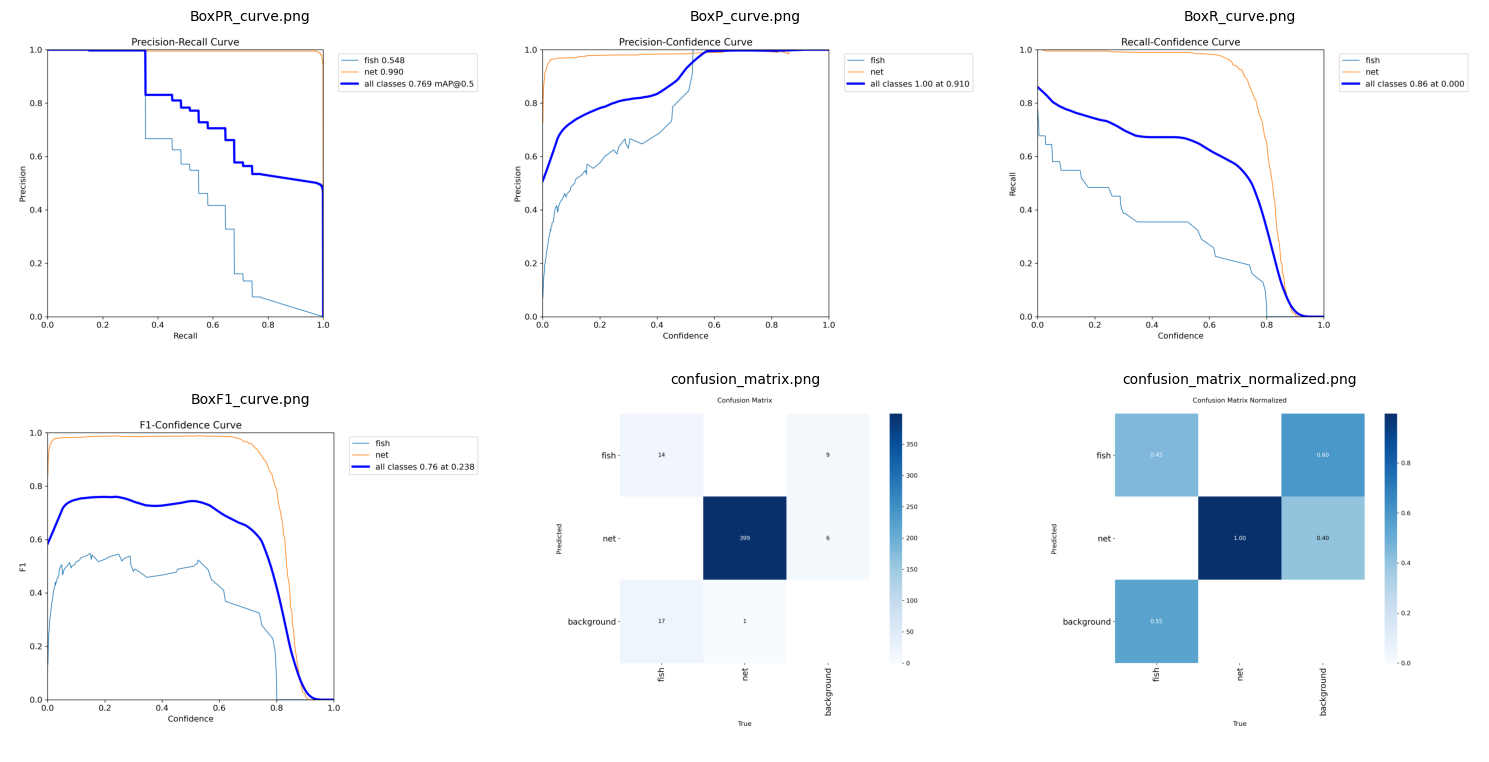

In [4]:
from utils.evaluation_utils import plot_evaluation_metrics

%matplotlib inline

run_dir = "../runs_aquayolo/EVAL_net_fish_cfc_sonar"

plot_evaluation_metrics(run_dir)

### Show predictions

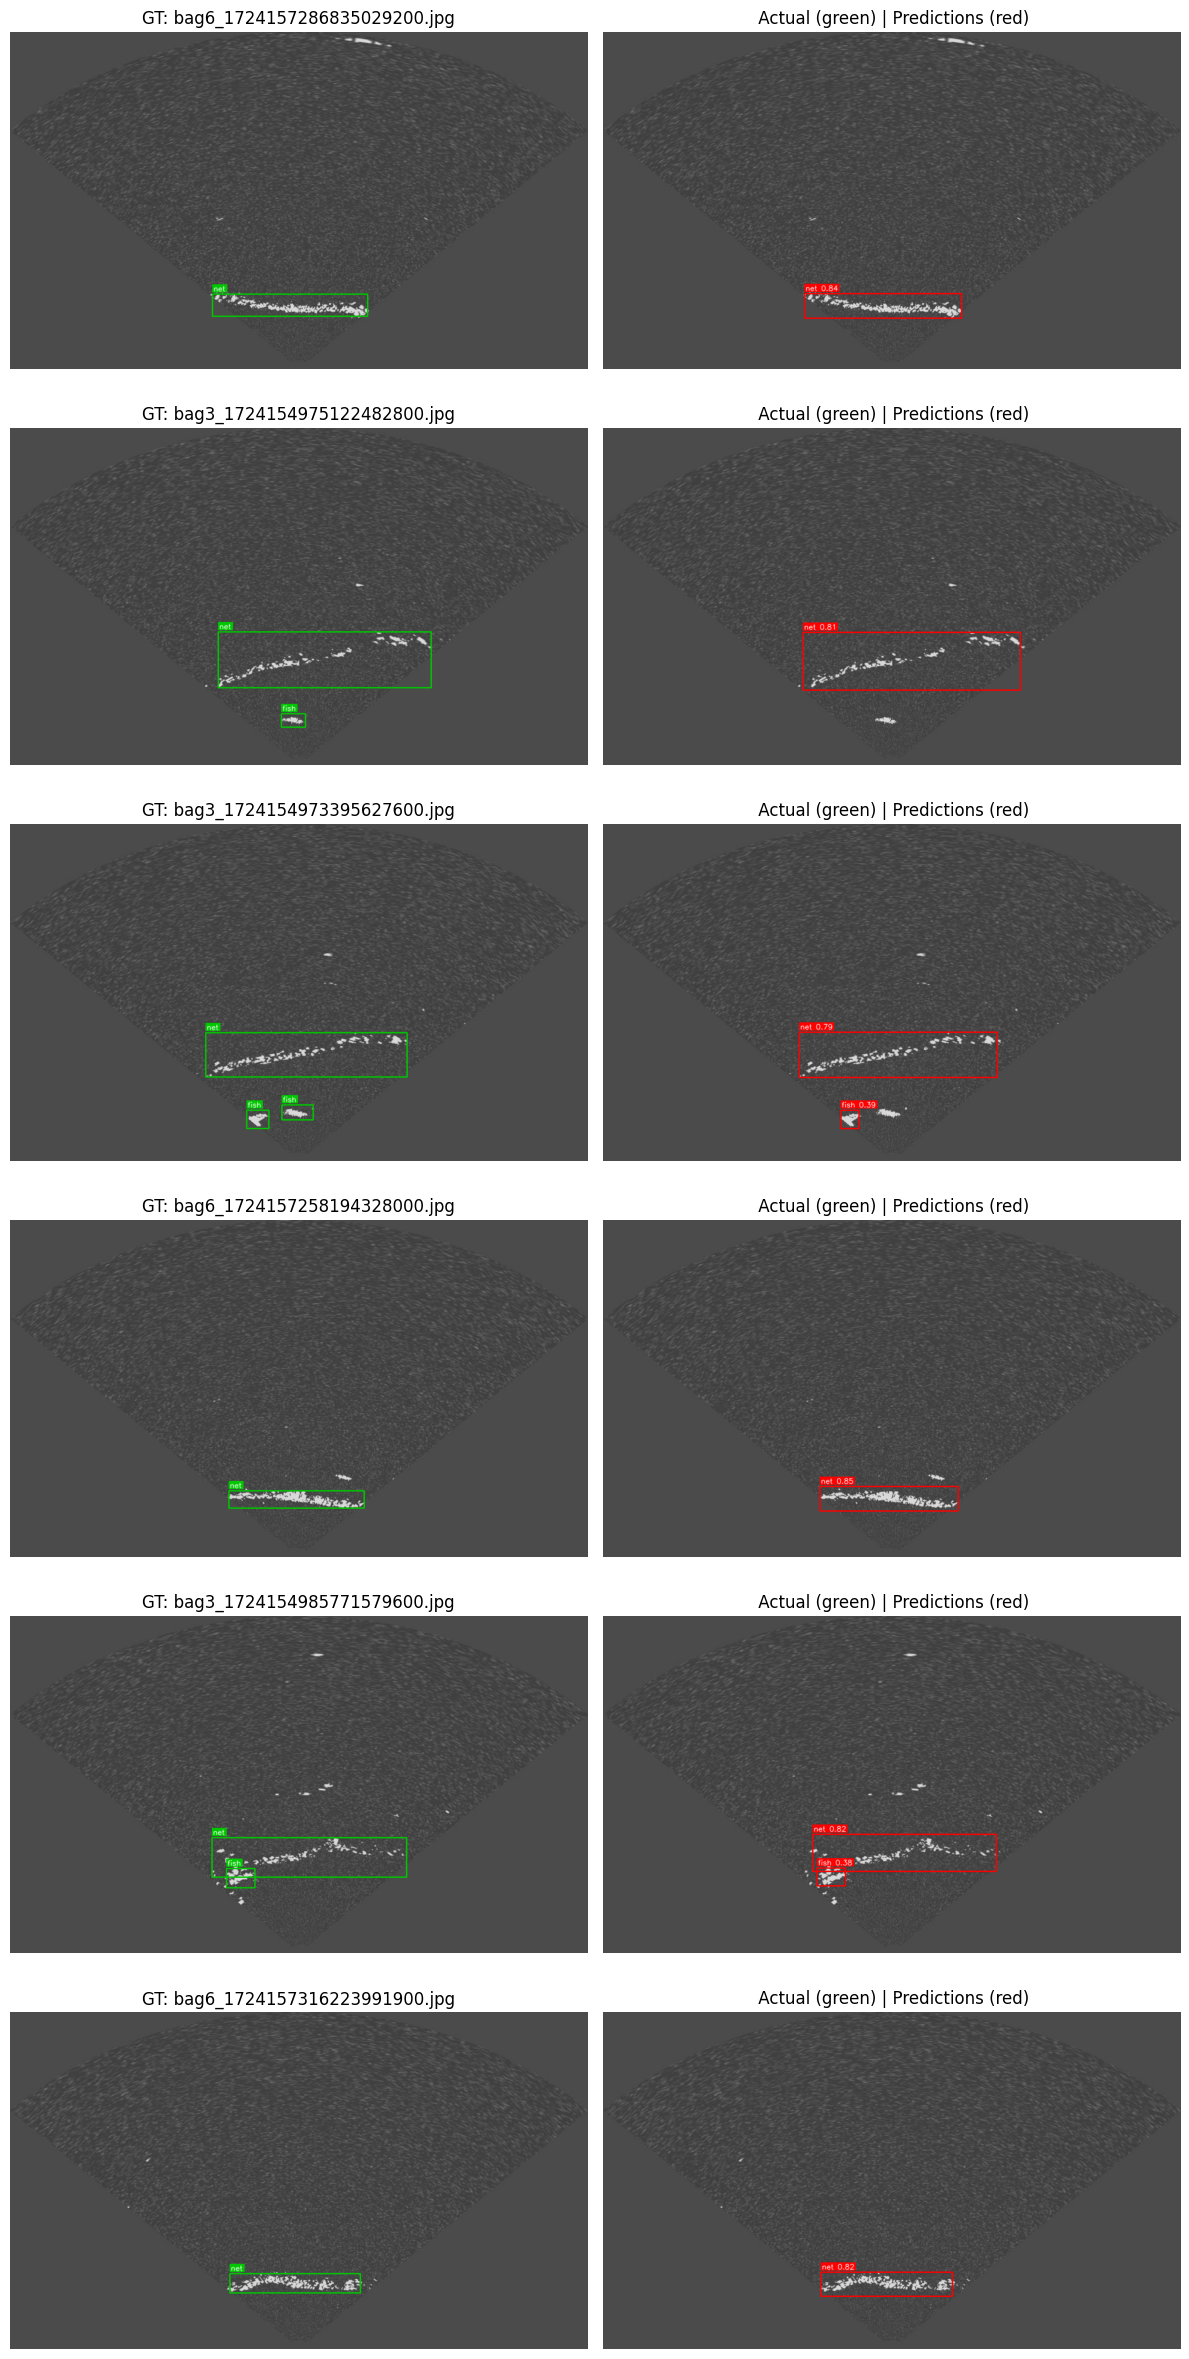

In [9]:
from utils.evaluation_utils import plot_yolo_predictions_samples

plot_yolo_predictions_samples(
    images_dir="../../solaqua/data/net_fish_sonar_split/images/val",
    labels_dir="../../solaqua/data/net_fish_sonar_split/labels/val",
    weights="../runs_aquayolo/net_fish_cfc_sonar_SGD_1280_lightaug/weights/best.pt",
    num_samples=6,
    conf_thres=0.25,
    imgsz=640
)